# Simulation Based Inference

This tutorial will explore the method of simulation based inference, a form of likelihood free inference, as implemented in the sbi package.

This notebok is a demonstration of the tutorial provided by the developers or sbi and can be found [here](https://www.mackelab.org/sbi/tutorial/01_gaussian_amortized/) 

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
import scipy.integrate as integrate

import sbi.utils as utils
from sbi.inference.base import infer

Create three parameters with a uniform distribution between -2 and 2. 

In [2]:
dims = 3
prior = utils.BoxUniform(low=-2*torch.ones(dims), high=2*torch.ones(dims))

Define a linear function on which to perform inference. 

In [3]:
f = lambda theta: theta + 1.0 + torch.randn_like(theta) * 0.1 

In [4]:
posterior = infer(f, prior, 'SNPE', num_simulations=1000)


Neural network successfully converged after 106 epochs.


In [5]:
x_o_1 = torch.zeros(3,)
x_o_2 = 2.0*torch.ones(3,)

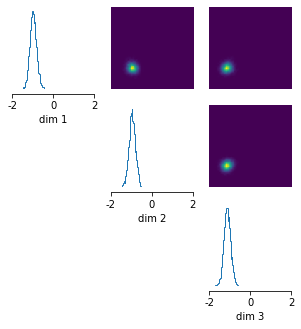

In [6]:
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

_ = utils.pairplot(posterior_samples_1, limits=[[-2,2],[-2,2],[-2,2]], fig_size=(5,5))



In [7]:
x = np.array(posterior_samples_1[:,0])

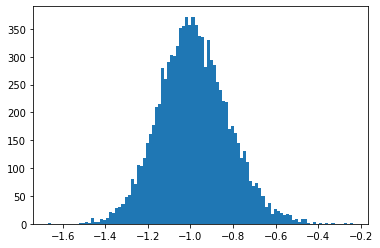

In [8]:
plt.hist(x, bins=100)
plt.show()

## Exponential Decay Model

Here, we will look at applying sbi to a simple model of exponential decay. We will generate data by adding Gaussian noise to the model results. 

In [9]:
def f(theta): 
    """ Sipmle exponential decay model

    args: 
    theta : array, float
            parameters for function
        t : array, float 
            timesteps to evaluate at
    """
    a, l = theta
    f = a * np.exp(-l * t)

    return f

In [44]:
a = 35
l = 2
theta = [a, l]
t = np.linspace(0,20,100)

model = f(theta)
data = f(theta) + np.random.normal(0, 1, t.shape[0])

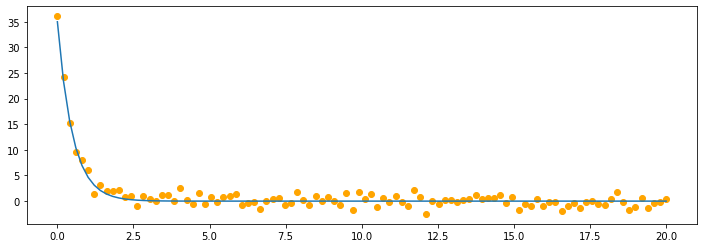

In [45]:
plt.figure(figsize=(12,4))
plt.plot(t, model)
plt.scatter(t, data, c = 'orange')
plt.show()

Set number of dimensions and priors on parameters

In [50]:
dims = 2

# learn to change to gaussian priors 

prior = utils.BoxUniform(low=torch.tensor([30., 0.]),
    high=torch.tensor([40., 5.]))

prior2 = utils.BoxUniform(low=torch.tensor([20., 0.]),
    high=torch.tensor([50., 10.]))

In [56]:
posterior = infer(f, prior, 'SNPE', num_simulations=1000, num_workers=4)


Neural network successfully converged after 192 epochs.


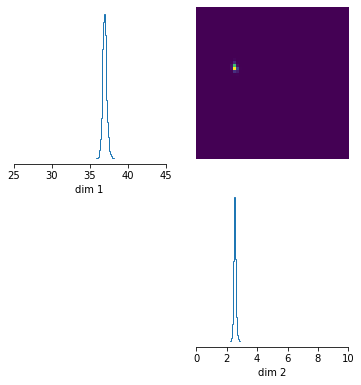

In [52]:
posterior_samples = posterior.sample((100000,), x=data)
_ = utils.pairplot(posterior_samples, limits=[[25, 45],[0, 10]], fig_size=(6,6))

## Fitzhugh-Nagumo Model: Parameter Estimation

Having used sbi on a simple model, we will now try a slightly more complicated mode, notably the Fitzhugh-Nagumo model. 

In [13]:
def fitzhugh_nagumo(u, t, p):

    v, w = u
    a, b, I, R, tau = p

    dvdt = v - (v**3)/3 - w  + R * I

    dwdt = (v + a - (b * w)) / tau

    return [dvdt, dwdt]

def simulate(u):

    p = [0.7, 0.8, 0.34, 1.0, 10]
    t = np.arange(0.0, 1000, 0.1)

    sol = integrate.odeint(fitzhugh_nagumo, u, t, args=(p,))
    return sol[:,0]

In [15]:
u = [-2.0, 1.0]

model = simulate(u)
data = model + np.random.normal(0, 1, model.shape[0])

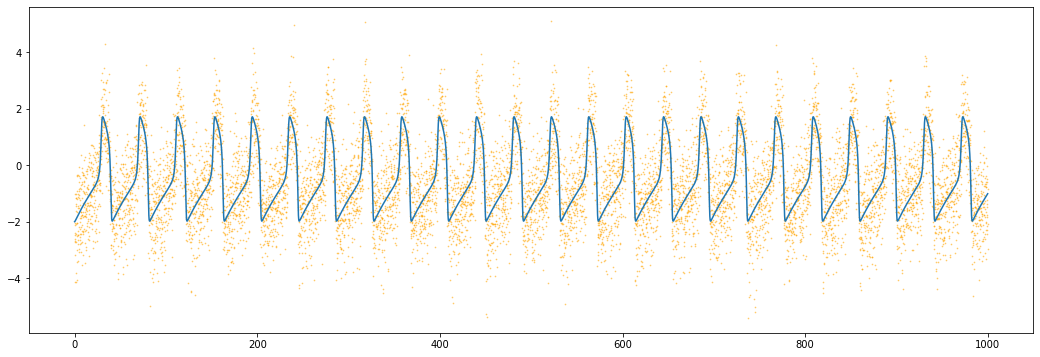

In [17]:
t = np.arange(0.0, 1000, 0.1)

plt.figure(figsize=(18,6))
plt.plot(t, model)
plt.scatter(t, data, c = 'orange', s = 0.5, alpha=0.5)
plt.show()

In [29]:
dims = 2

prior = utils.BoxUniform(low=torch.tensor([-5., -5.]),
    high=torch.tensor([5., 5.]))

In [30]:
posterior = infer(simulate, prior, 'SNPE', num_simulations=1000, num_workers=4)


Neural network successfully converged after 112 epochs.


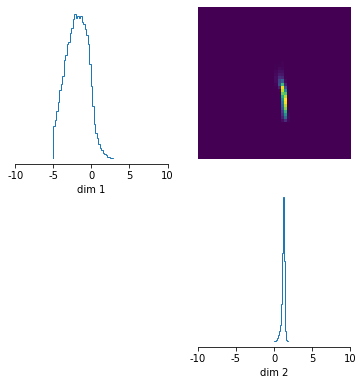

In [31]:
posterior_samples = posterior.sample((100000,), x=data)
_ = utils.pairplot(posterior_samples, limits=[[-10, 10],[-10, 10]], fig_size=(6,6))

In [42]:
u = torch.mean(posterior_samples[:,0]), torch.mean(posterior_samples[:,1])
inferred = simulate(u)

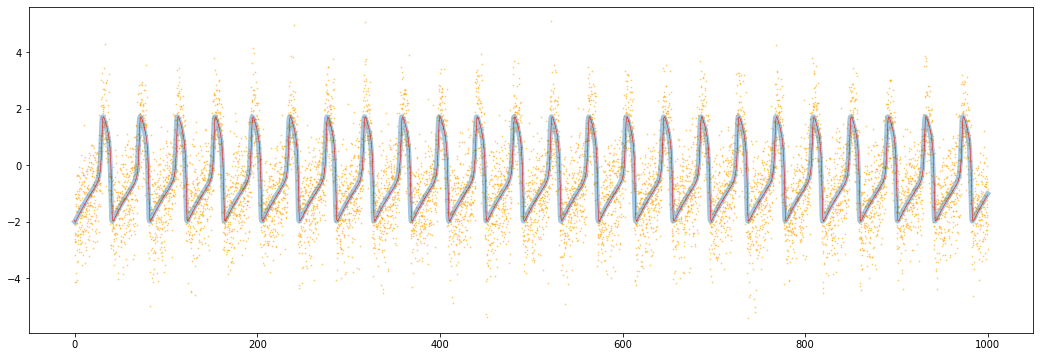

In [55]:
t = np.arange(0.0, 1000, 0.1)

plt.figure(figsize=(18,6))
plt.plot(t, model, linewidth = 5, alpha=0.4)
plt.plot(t, inferred, c = 'r', alpha = 1, linewidth = 0.5)
plt.scatter(t, data, c = 'orange', s = 0.5, alpha=0.5)
plt.show()